In [5]:
import numpy as np
import trimesh as tri
import torch
import open3d as o3d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os

sys.path.insert(0,"../")

from utils import mesh_processing

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


## Import data

In [6]:
sphere = tri.creation.uv_sphere(count=[16, 16])

In [7]:
def get_data(file):
    mesh = o3d.io.read_triangle_mesh(file)
    V, F, Rho = mesh_processing.getDataFromMesh(mesh)
    return(V,F,Rho)

V,F,Rho = get_data("../data/test_data/bunny.ply")

mesh = tri.Trimesh(V,F)

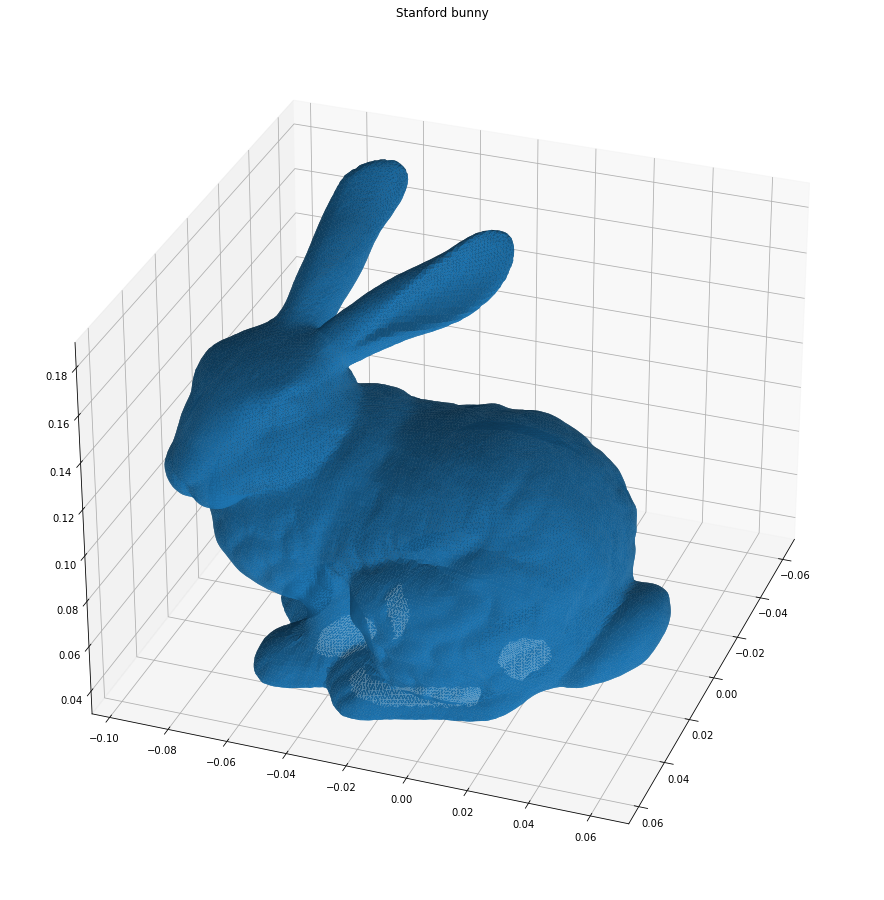

In [8]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(mesh.vertices[:, 2], mesh.vertices[:,0], triangles=mesh.faces, Z=mesh.vertices[:,1])
ax1.set_title("Stanford bunny")
ax1.view_init(30, 20)
plt.show()

In [9]:
def f_x(x,y,z):
    return()

## Function on the sphere

In [ ]:
sphere.vertices

TrackedArray([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
              [ 1.01168322e-01,  0.00000000e+00,  9.94869323e-01],
              [ 2.01298520e-01,  0.00000000e+00,  9.79529941e-01],
              ...,
              [ 2.00298223e-01, -2.00428602e-02, -9.79529941e-01],
              [ 1.00665594e-01, -1.00731120e-02, -9.94869323e-01],
              [ 1.21856125e-16, -1.21935445e-17, -1.00000000e+00]])

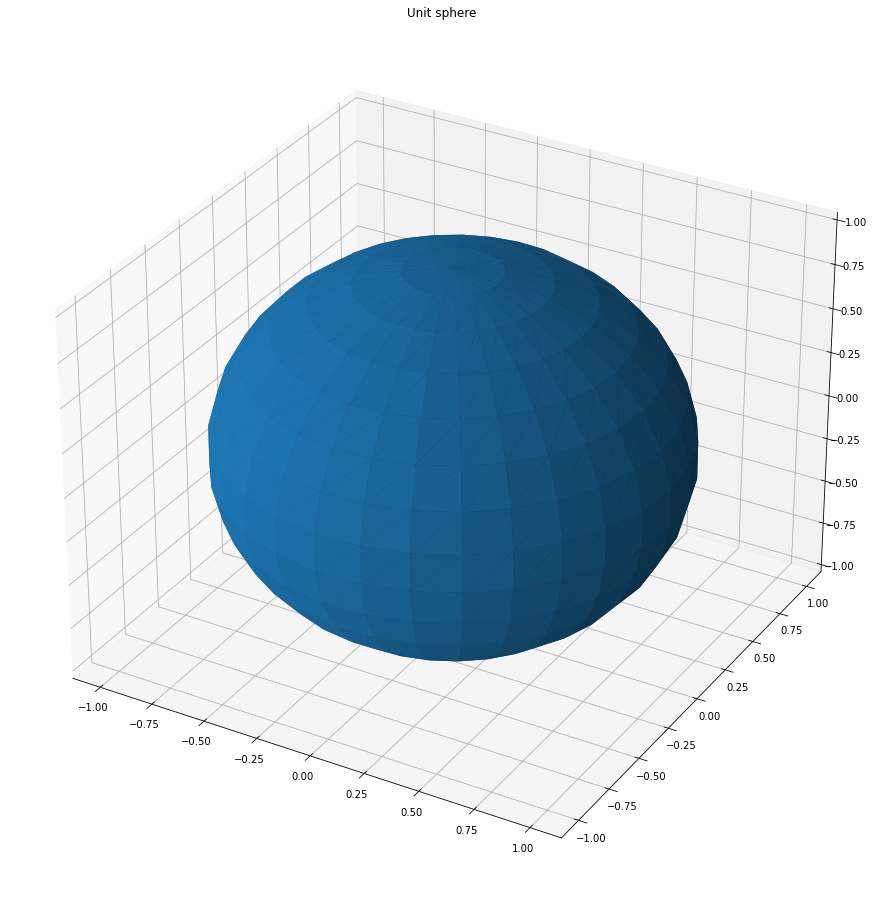

In [10]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(sphere.vertices[:, 0], sphere.vertices[:,1], triangles=sphere.faces, Z=sphere.vertices[:,2])
ax1.set_title("Unit sphere")
plt.show()

In [11]:
x, y, z = sphere.vertices[:,0], sphere.vertices[:,1], sphere.vertices[:,2]

In [12]:
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z/r)
phi = np.arctan(x,y)

In [13]:
def cart(theta, phi):
    return(np.cos(phi)*np.sin(phi), np.sin(phi)*np.sin(theta), np.cos(theta))

In [14]:
def phi0(t):
    if 0 <= t < 1:
        return 1
    return 0

def psi0(t):
    if 0 <= t <(1/2):
        return 1
    elif 1/2 <= t <= 1:
        return -1
    return 0

# Spherical harmonic decomposition

In [15]:
import pyssht
sphere = tri.creation.uv_sphere(count=[16, 16])

In [16]:
x, y, z = sphere.vertices[:,0], sphere.vertices[:,1], sphere.vertices[:,2]
r, theta, phi = pyssht.cart_to_spherical(x, y, z)
omega = np.array([theta,phi])

In [17]:
@np.vectorize
def f_r(theta, phi):
    return(1.0)

@np.vectorize
def f_theta(theta, phi):
    return(theta)

@np.vectorize
def f_phi(theta, phi):
    return(phi)

In [18]:
THETA, PHI = np.meshgrid(np.array(theta),np.array(phi))

r_coord = f_r(theta,phi)
theta_coord = f_theta(theta,phi)
phi_coord = f_phi(theta,phi)

(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(r_coord, theta_coord, phi_coord)

In [19]:
r_coord = f_r(THETA,PHI)
theta_coord = f_theta(THETA,PHI)
phi_coord = f_phi(THETA,PHI)

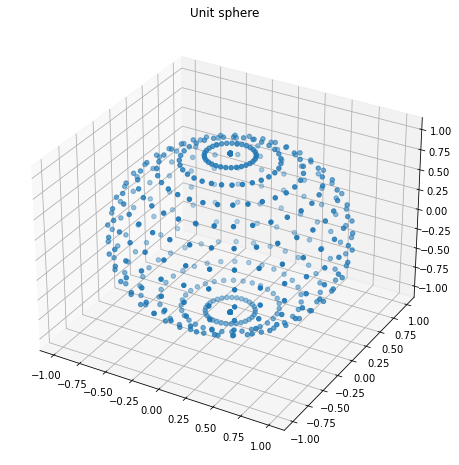

In [20]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")
plt.show()

In [ ]:
flm_r = pyssht.forward(r_coord, 64, Spin=0, Method='MWSS', Reality=True)
flm_theta = pyssht.forward(theta_coord, 64, Spin=0, Method='MWSS', Reality=True)
flm_phi = pyssht.forward(phi_coord, 64, Spin=0, Method='MWSS', Reality=True)

In [ ]:
f_reconstruct_r = pyssht.inverse(flm_r, 128, Spin=0, Method='MWSS', Reality=True)
f_reconstruct_theta = pyssht.inverse(flm_theta, 12, Spin=0, Method='MWSS', Reality=True)
f_reconstruct_phi = pyssht.inverse(flm_phi, 4096, Spin=0, Method='MWSS', Reality=True)

In [ ]:
(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(f_reconstruct_r, f_reconstruct_theta, f_reconstruct_phi)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")
plt.show()

In [ ]:
pyssht.plot_sphere(
    f_reconstruct, 64, Method='MWSS', Close=True, Parametric=False,
    Parametric_Scaling=[0.0,0.5], Output_File=None,
    Show=True, Color_Bar=True, Units=None, Color_Range=None,
    Axis=True
)

## With SHTools